# Not Hotdog

---

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(1)

%load_ext autoreload
%autoreload 2
%aimport utils

# select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 954695604725781560, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11285974221
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5061012724459261623
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

_(many functions were placed in `utils.py` in order to make the code cleaner and I will import them directly from that file)_

## Data loading and image representation

In [19]:
from PIL import Image

data_folder = "./data/"

path = data_folder + "hotdog/893996.jpg"

# read image
image = Image.open(path)

# resize image
height = 64
width = 64
image = image.resize((height, width))

# transform the image to array
image = np.array(image)

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [20]:
image.shape

(64, 64, 3)


We can visualize the loaded image using

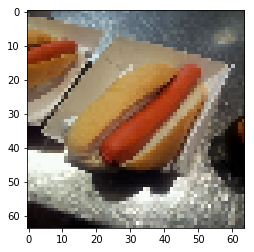

In [21]:
plt.figure(figsize=(4,4))
plt.imshow(image)

### Read images and resize them

I create a function inside `utils` to read images from a given path and resize them to have the every image on the dataset with the same width and height.

Use the defined `read_images_from_path` function to read and resize all training and test images.

In [51]:
from utils import read_images_from_path

# define paths
img_hotdog_path = data_folder + 'hotdog'
img_not_hotdog_path = data_folder + 'not_hotdog'

# get images
img_hotdog = read_images_from_path(img_hotdog_path, height, width)
img_not_hotdog = read_images_from_path(img_not_hotdog_path, height, width)

Getting images from path: ./data/hotdog...
Getting images from path: ./data/not_hotdog...


### Image augmentation

As we have few images to train our model, we'll need more images to get our model to a proper training.

We'll use **Image augmentation**, which is a process that allow us to create new images by rotating, shifting, zooming and flipping our images. I will randomly generate new images from our small dataset images.

New images will be only to _train_ our model. Generating new images to _test_ our model could lead to unexpected results and biases on its evaluation.

In [52]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def generate_images_with_augmentation:
    datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            channel_shift_range=0.2,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest')

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    for image in img_hotdog:
        img = image.reshape((1,) + image.shape)  # this is a Numpy array with shape (1, color_channels, width, height)

        i = 0
        for batch in datagen.flow(img, batch_size=1,
                                  save_to_dir='data/more_hotdogs/', save_prefix='hotdog_aug', save_format='jpg'):
            i += 1
            if i >= 7: # 7 new images per image
                break

#generate_images_with_augmentation() # comment this line if new images are already generated
            
# add the new images to our hotdog images
img_more_hotdog_path = data_folder + 'more_hotdogs'

img_hotdog = img_hotdog + read_images_from_path(img_more_hotdog_path, height, width)

Getting images from path: ./data/more_hotdogs...


Create `X_train`, `Y_train`, `X_test` and `Y_test` partitions.

In [53]:
from sklearn.model_selection import train_test_split

test_split_size = 0.2

img_hotdog_train, img_hotdog_test, \
tag_hotdog_train, tag_hotdog_test = train_test_split(img_hotdog,
                                                     len(img_hotdog) * [0],
                                                     test_size=test_split_size,
                                                     random_state=1)

img_not_hotdog_train, img_not_hotdog_test, \
tag_not_hotdog_train, tag_not_hotdog_test = train_test_split(img_not_hotdog,
                                                             len(img_not_hotdog) * [1],
                                                             test_size=test_split_size,
                                                             random_state=1)

In [54]:
X_train = np.asarray(img_hotdog_train + img_not_hotdog_train)
Y_train = np.asarray(tag_hotdog_train + tag_not_hotdog_train)

X_test = np.asarray(img_hotdog_test + img_not_hotdog_test)
Y_test = np.asarray(tag_hotdog_test + tag_not_hotdog_test)

#print(X_train[0].shape)
#print(Y_train)

If everything has been properly loaded both X_train and Y_train lists should have equal length, and the same should happen for the pair X_test and Y_test.

In [55]:
print("X_train size", len(X_train))
print("Y_train size", len(Y_train))
print("X_test size", len(X_test))
print("Y_test size", len(Y_test))

class_names = ['Hot dog', 'Not hot dog']

X_train size 2970
Y_train size 2970
X_test size 744
Y_test size 744


Show some **Hot dog** images:

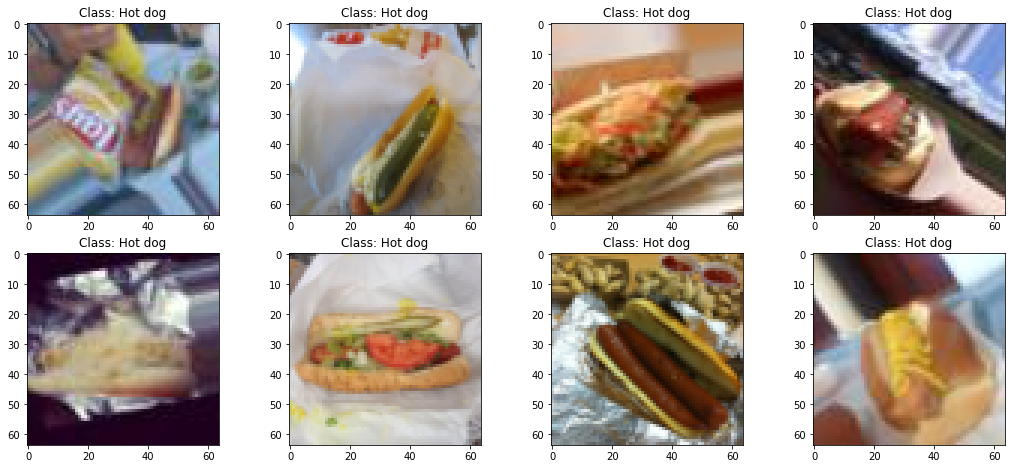

In [56]:
plt.figure(figsize=(18, 12))

for i in range(0, 8):
    image_index = i
    Y_test_binary = Y_train[image_index]

    plt.subplot(3, 4, i+1)
    plt.imshow(X_train[image_index])
    plt.title('Class: {}'.format(class_names[Y_test_binary]))
    
# show the plot
plt.show()

Show some **Not hot dog** images:

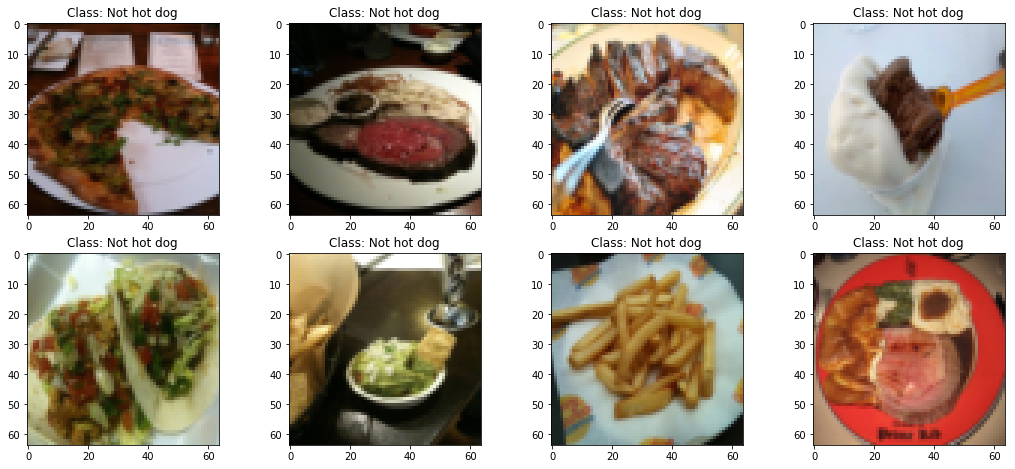

In [57]:
plt.figure(figsize=(18, 12))

for i in range(0, 8):
    image_index = i + len(img_hotdog_train)
    Y_test_binary = Y_train[image_index]

    plt.subplot(3, 4, i+1)
    plt.imshow(X_train[image_index])
    plt.title('Class: {}'.format(class_names[Y_test_binary]))
    
# show the plot
plt.show()

## Data preprocessing

For efficiency in batch processing, in keras all input patterns should have equal dimensions. Even more, when working with images keras expects as training input a 4-dimensional matrix with dimensions (patterns, image_width, image_height, color_channels). Therefore, you must preprocess the data into this format. It is also highly recommended to rescale the pixel values to make them lie in the range [0,1]. Finally, you might also need to perform some transformation on the outputs Y.

In [58]:
from keras.utils import np_utils

# images are already resized to 30x40 pixels

# normalize data: rescale pixel values to the range [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# we should change the class encoding to something more akin to neural networks,
# instead of having a single integer ranging [0,1] to encode the different classes,
# we will use a one-hot vector encoder to codify that 2 classes
n_classes = 2

Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)

In [59]:
# preprocess the data into [patterns, image_width, image_height, color_channels] format
color_channels = X_train.shape[3]
train_patterns = X_train.shape[0]
test_patterns = X_test.shape[0]

train_tensor = X_train.reshape(train_patterns, width, height, color_channels)
test_tensor = X_test.reshape(test_patterns, width, height, color_channels)

print('train_tensor.shape: {}'.format(train_tensor.shape))
print('Y_train.shape: {}'.format(Y_train.shape))

print('test_tensor.shape: {}'.format(test_tensor.shape))
print('Y_test.shape: {}'.format(Y_test.shape))

train_tensor.shape: (2970, 64, 64, 3)
Y_train.shape: (2970, 2)
test_tensor.shape: (744, 64, 64, 3)
Y_test.shape: (744, 2)


## Deep model

Create a deep network that solves the classification problem using the layers that seem fit for problem.

### Convolutional network configuration

In [60]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Convolution1D, GlobalAveragePooling1D
from keras.optimizers import Adam


def build_model():
    model = Sequential()
    model.add(Conv2D(64, (2, 2), input_shape=(width, height, color_channels), activation='relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (2, 2), activation='relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling2D())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    return model

In [61]:
import numpy as np
np.random.seed(1) # for reproducibility

model = build_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 63, 63, 64)        832       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        8224      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33792     
__________

In [62]:
%%time

epochs = 40
batch_size = 64

model_history = model.fit(
    train_tensor,
    Y_train,
    steps_per_epoch = len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(test_tensor, Y_test),
    validation_steps = len(X_test) // batch_size,
    verbose=1
)

Train on 2970 samples, validate on 744 samples
Epoch 1/40
46/46 [==============================] - 36s 778ms/step - loss: 0.3924 - acc: 0.8555 - val_loss: 0.3749 - val_acc: 0.8656
Epoch 2/40
46/46 [==============================] - 34s 746ms/step - loss: 0.3684 - acc: 0.8677 - val_loss: 0.3462 - val_acc: 0.8710
Epoch 3/40
46/46 [==============================] - 34s 749ms/step - loss: 0.3592 - acc: 0.8690 - val_loss: 0.3388 - val_acc: 0.8710
Epoch 4/40
46/46 [==============================] - 34s 750ms/step - loss: 0.3505 - acc: 0.8735 - val_loss: 0.3749 - val_acc: 0.8656
Epoch 5/40
46/46 [==============================] - 34s 749ms/step - loss: 0.3488 - acc: 0.8715 - val_loss: 0.3237 - val_acc: 0.8750
Epoch 6/40
46/46 [==============================] - 34s 748ms/step - loss: 0.3423 - acc: 0.8747 - val_loss: 0.3227 - val_acc: 0.8710
Epoch 7/40
46/46 [==============================] - 34s 748ms/step - loss: 0.3345 - acc: 0.8770 - val_loss: 0.3286 - val_acc: 0.8737
Epoch 8/40
46/46 [====

744/744 [==============================] - 0s 159us/step
Test loss 0.21282176721480586
Test accuracy 0.9112903225806451


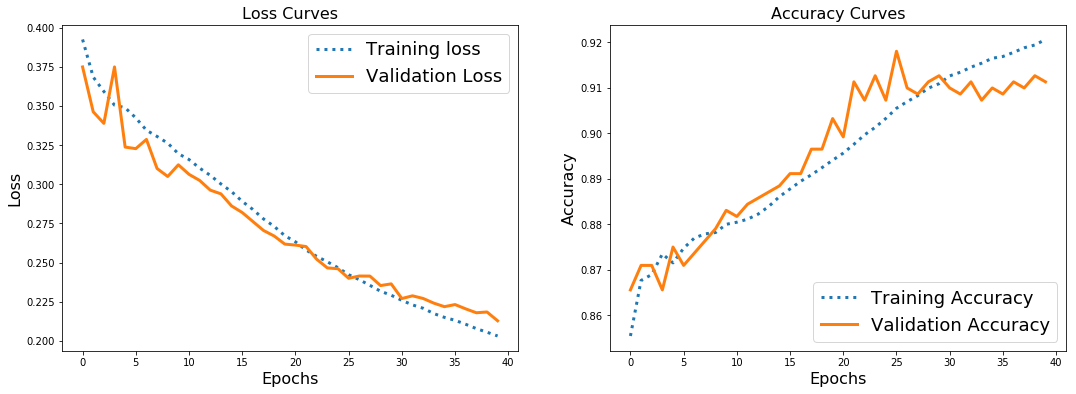

In [63]:
from utils import plot_loss_and_accuracy

score = model.evaluate(test_tensor, Y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

plot_loss_and_accuracy(model_history)

In this case adding more epochs ends making the model overfit (increasing the test loss), so I keep 20 epochs.

In [64]:
#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
preds = model.predict_classes(test_tensor)

Y_test_binary = np.argmax(Y_test,axis=1)
confusion_matrix = confusion_matrix(Y_test_binary, preds)

confusion_matrix

array([[612,  32],
       [ 34,  66]])

### Show some images for which the model fails

Although we've got a pretty good test accuracy, the remaining percentage of images may fail, out model is not 100% effective _–and these models don't exist–_.

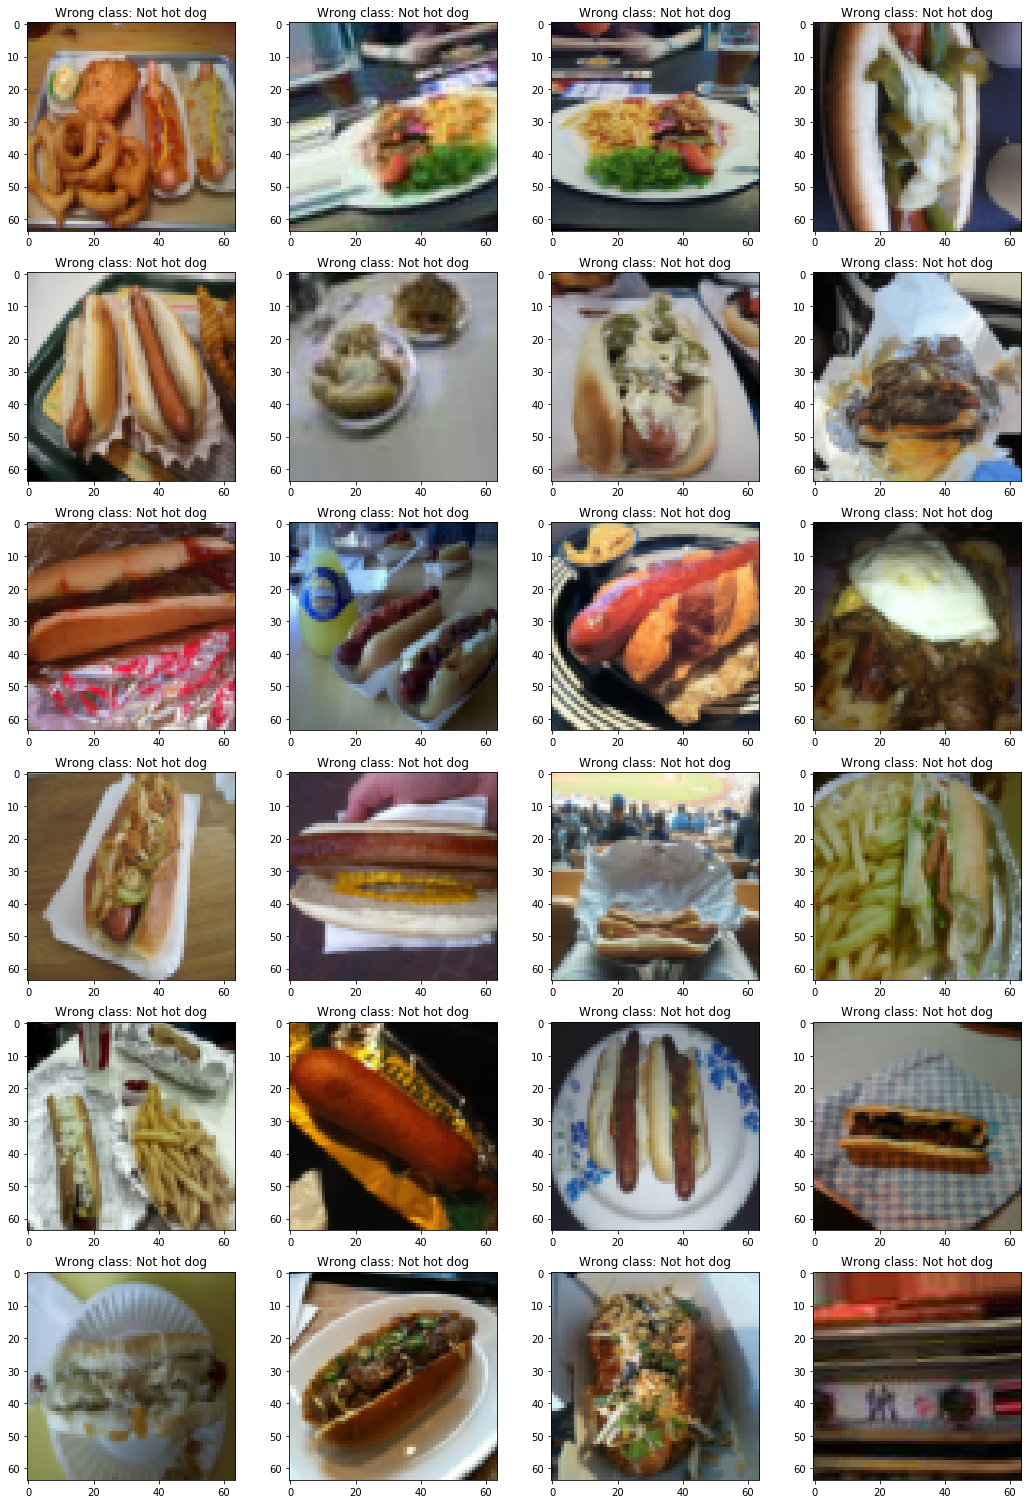

In [65]:
correct_predictions = preds == Y_test_binary
incorrect_images = test_tensor[~correct_predictions]
incorrect_images_index = [i for i, x in enumerate(correct_predictions) if not x]

plt.figure(figsize=(18, 36))
X_batch=[]

for i in range(0, 24):
    plt.subplot(8, 4, i+1)
    plt.imshow(incorrect_images[i])

    incorrect_image_pred_position = incorrect_images_index[i]
    incorrect_image_class = class_names[preds[incorrect_image_pred_position]]
    plt.title('Wrong class: {}'.format(incorrect_image_class))

# show the plot
plt.show()

---